# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import chi2_contingency 
from tqdm import tqdm

import requests
from urllib.parse import urlencode

import seaborn as sns
sns.set(rc={"figure.figsize": (12, 8)})

## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

Загрузили датафреймы, посмотрим на них повнимательнее

In [3]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [4]:
reg_data.shape

(1000000, 2)

In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
reg_data.duplicated().sum()

0

In [7]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [9]:
auth_data.shape

(9601013, 2)

In [10]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [11]:
auth_data.duplicated().sum()

0

In [12]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [13]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [14]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


В данных нет ни дубликатов ни пропусков.

Можно начинать предобработку.
Для начала переведем все даты их UNIX формата в привычный datetime

In [15]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data['reg_ts'] = reg_data.reg_ts.astype('datetime64[D]')

In [16]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data['auth_ts'] = auth_data.auth_ts.astype('datetime64[D]')

In [17]:
df = reg_data.merge(auth_data, how='inner', on='uid') 
# объединяем все в один датафрейм

In [18]:
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [19]:
def retention(df, begin, days):
    '''Принимает рбъединенный df, дату старта отсчета и количество дней, возвращает график retention'''
    
    begin = begin  # Дата начата расчета Retention
    end = begin + pd.Timedelta(days=days)
    
    df = df.query('reg_ts >= @begin and auth_ts <= @end')\
        .groupby(['reg_ts', 'auth_ts'], as_index=False) \
        .agg(users=('uid', 'nunique'))
    
    df['day_delta'] = (df['auth_ts'] - df['reg_ts']).dt.days
       
    #  Собираем итоговую таблицу
    retention = df.pivot_table(index='reg_ts', columns='day_delta', values='users')
    retention = retention.divide(retention.iloc[:, 0], axis=0)
    
       
    plt.figure(figsize=(30, 16))
    plt.title('Retention', fontsize=20)
    ax = sns.heatmap(data=retention, annot=True, vmin=0.0, vmax=0.25, fmt='.1%')
    ax.set_yticklabels(retention.index.strftime('%Y-%m-%d'), fontsize=10)
    plt.show()

Дата первой регистрации 1998-11-18, дата последней регистрации 2020-09-23
Рекомендуется смотреть метрики за период до 14 дней, допускается просмотр за 30 дней, при выборе большего диапазона визуализация плохо воспринимается глазом.

In [20]:
print('Укажите дату начала отсчета в формате гггг-мм-дд')
begin = pd.to_datetime(input())
print('Укажите количество дней расчета')
days = int(input())

Укажите дату начала отсчета в формате гггг-мм-дд
2017-06-10
Укажите количество дней расчета
18


In [52]:
print(retention.__doc__)

Принимает рбъединенный df, дату старта отсчета и количество дней, возвращает график retention


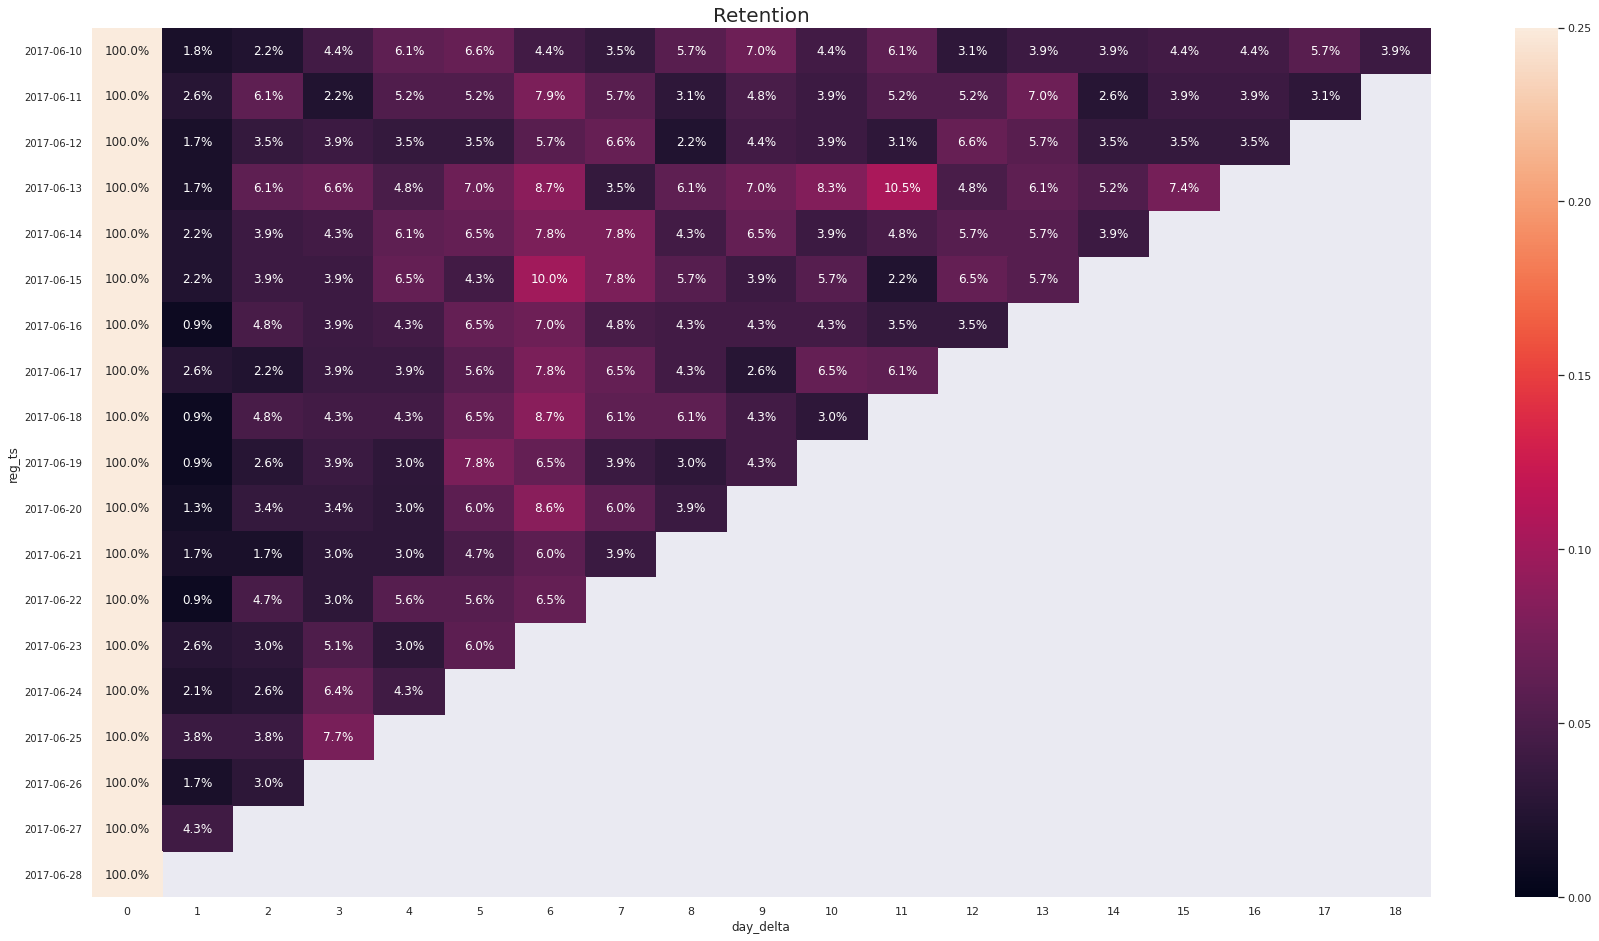

In [21]:
retention(df, begin, days)

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Сначала посмотрим на данные

In [22]:
# используем api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

# получаем ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# создаем датафрейм, с которым будем работать
download_response = requests.get(download_url)
ab_result = pd.read_csv(download_url, sep=';')

In [23]:
ab_result.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


a - контрольная группа;
b - тестовая группа

In [24]:
ab_result.shape

(404770, 3)

In [25]:
ab_result.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [26]:
ab_result.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [27]:
ab_result.groupby('testgroup') \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'all_users'})

#  смотрим общее кол-во пользователей

,all_users
testgroup,
a,202103
b,202667


In [28]:
ab_result.query('revenue > 0') \
    .groupby('testgroup') \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'clients'})

#  смотрим общее кол-во платящих пользователей

,clients
testgroup,
a,1928
b,1805


In [29]:
ab_result.query('revenue > 0') \
    .groupby(['testgroup'])['revenue'] \
    .agg(['mean', 'median']) \
    .round()

#  сравниваем средние и медианные значения выручки двух групп

,mean,median
testgroup,,
a,2664.0,311
b,3004.0,3022


Мы видим небольшие различия в средних значениях, и разницу почти в десять раз в медианных значениях.
Хочется посмотреть поближе и визуализировать  распределения

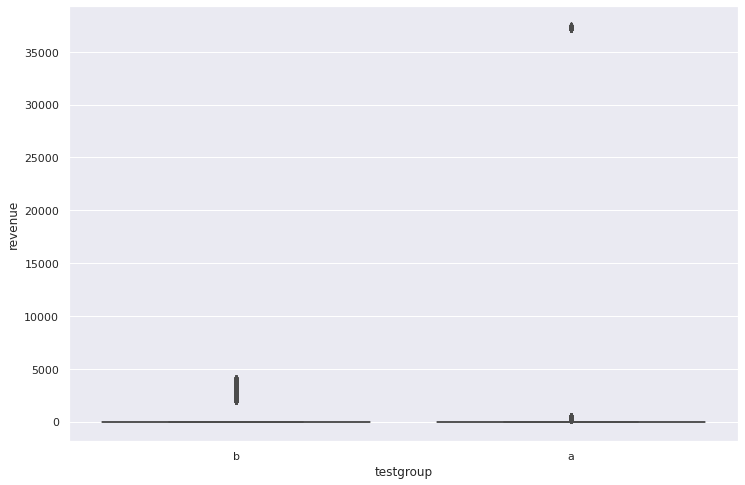

In [30]:
sns.boxplot(x='testgroup', y='revenue', data=ab_result)

In [31]:
ab_df_a = ab_result.query("testgroup == 'a'")
ab_df_b = ab_result.query("testgroup == 'b'")

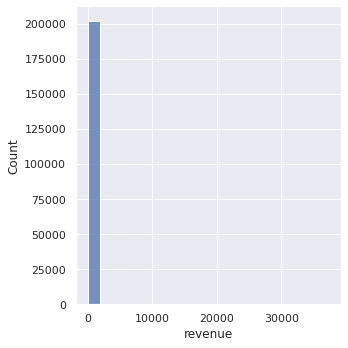

In [32]:
sns.displot(ab_df_a.revenue, kde=False)

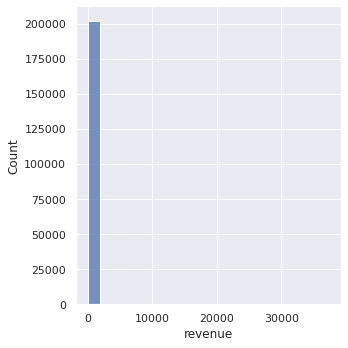

In [33]:
sns.displot(ab_df_a.revenue, kde=False)

Боксплот и гистограмма оказались не самыми удачными вариантами визуализировать распределения, здесь лучше отработал скаттерплот

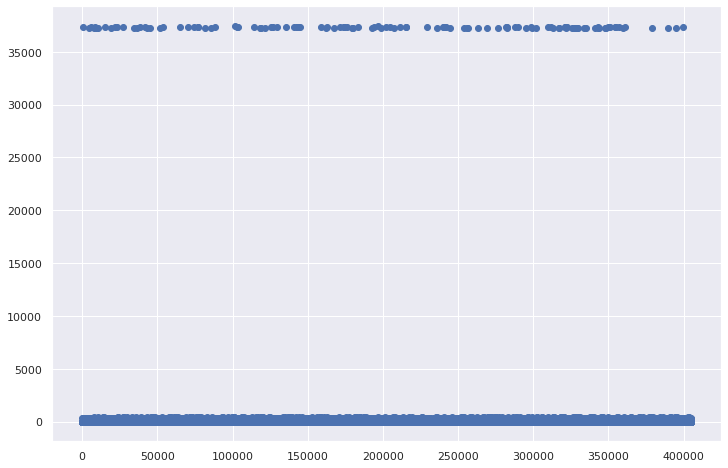

In [34]:
plt.scatter('user_id', 'revenue', data=ab_df_a) 

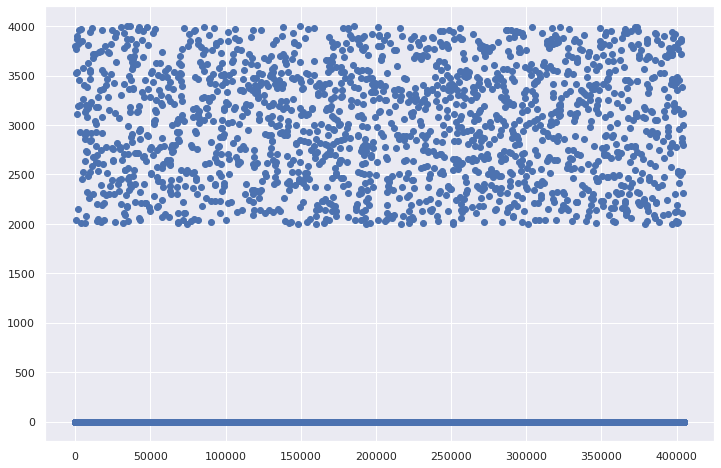

In [35]:
plt.scatter('user_id', 'revenue', data=ab_df_b) 

In [36]:
ab_df_a.query('revenue > 0') \
    .revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [37]:
ab_df_b.query('revenue > 0') \
    .revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Графики и описания помогают нам сделать предварительные выводы.
Мы видим, что в контрольной группе есть очень сильный разрыв между пользователями.
75% пользователей приносят менее 400, в то время, как небольшое количесвто пользователей совершают аномально дорогие покупки, создавая выбросы.

В тестовой группе таких выбросов нет, все платящие пользователи более-менее равномерно распределены в диапазоне от 2000 до 4000(какие красивые круглые числа).

Вообще данные кажутся странными, и группы различаются они колоссально, но пока что у нас нет оснований принимать каких либо решений, поэтому примем на веру, что выборки собраны верно и репрезентативно.

У нас в двух группах есть небольшие различия в количестве юзеров, кто не совершает покупок, поэтому я предлагаю изучить CR и ARPPU, ибо на певый взгяд кажется, что целью эксперимента было именно увеличение конверсии и среднего чека у платящих пользователей.

### Перейдем к статистике

#### Сначала разберемся с конверсией
Необходимо понять повлиял ли A/B тест на показатель конверсии в покупку.

Для изучения необходимо использовать Хи-квадрат:
Создадим отдельный датафрейм для отображения пользователей.
Далее добавим маркер, чтобы было удобнее считать конверсию (0 - неплатящий, 1 - платящий).
В конце мы применим хи квадрат чтобы проверить гипотзы.

In [38]:
df_chi = ab_result

df_chi['conversion'] = df_chi['revenue'].apply(lambda x: x if x == 0 else 1)

In [39]:
df_chi.head()

,user_id,revenue,testgroup,conversion
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [40]:
cr_table = ab_result.groupby('testgroup') \
    .agg(all_users=('conversion', 'count'), paying=('conversion', 'sum'))

cr_table

,all_users,paying
testgroup,,
a,202103,1928
b,202667,1805


In [41]:
cr_a = (1928 / 202103) * 100
cr_b = (1805 / 202667) * 100

In [42]:
cr_a

0.9539690157988748

In [43]:
cr_b

0.8906235351586593

In [44]:
convertion_p = chi2_contingency(cr_table)[1]
convertion_p

0.03824373651044168

#### Вывод
Посчитав вручную конверсию мы видим, что в группе b, то есть тестовой значение ниже,
При этом p-value получился меньше 0.05, что подтверждает стат. значимость этих различий.

#### Теперь пора изучить ARPPU

Формируем 2 гипотезы:

##### H0: статистически значимых различий в ARPPU нет и 2 группы одинаковые
##### H1: есть статистически значимые различия в контрольной и тестовой группах.

Посмотрим на распредение платных клиентов

In [45]:
ab_df_a = ab_df_a.query('revenue > 0')
ab_df_b = ab_df_b.query('revenue > 0')

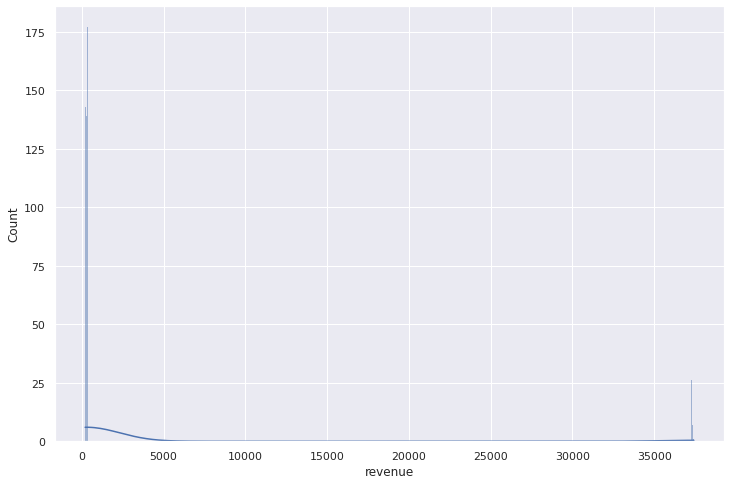

In [46]:
# Посмотрим на распределение выборок начиная c минимальной суммы покупки
sns.histplot(data=ab_df_a.query('revenue > 200'), x='revenue', kde=True)

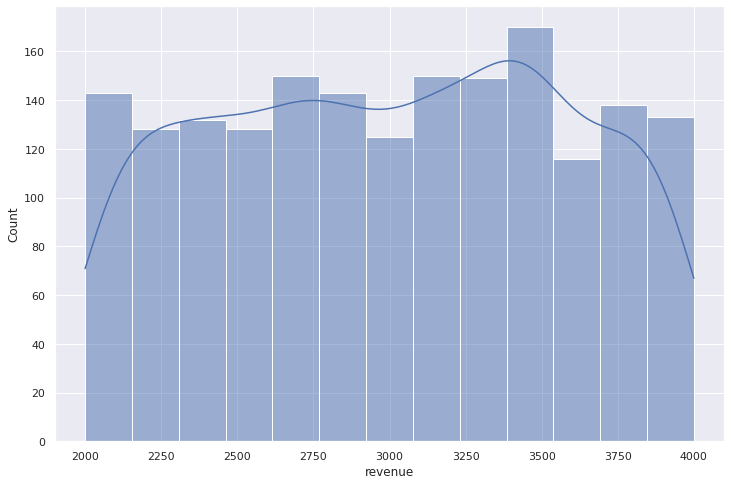

In [47]:
sns.histplot(data=ab_df_b.query('revenue > 200'), x='revenue', kde=True)

Распределения не выглядят нормальными, для подтверждения попробуем применить тест Шапиро-Уилка

In [48]:
shapiro(ab_df_a['revenue'])

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [49]:
shapiro(ab_df_b['revenue'])

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

В контрольной группе у нас есть основания отклонить гипотезу о нормальности распределения.

В случае с группой b я буду отталкиваться от визуальный параметров норм. распределения. Тест Шапиро не дал нам оснований принять альтернативную гипотезу и доказать что распределение ненормальное.

На данном этапе необходимо определиться с методом исследования.
Тест Манна-Уитни не буду использовать, так как его результаты сложны для интерпретации бизнесу, так как сравнивает не средние значения, а их ранги.

От Т-теста также отказываюсь, так как рапределения не являются нормальными, что допустимо, но с осторожностью, также наличие выбросов в одной из групп говорит не в пользу T-теста.

Наиболее удачным вариантом будет применение Бутстрэпа.

In [53]:
def get_bootstrap(
    data_column_1, 
    data_column_2,  
    boot_it=1000,  
    statistic=np.mean,  
    bootstrap_conf_level=0.95  
):
    '''Создаем функцию, которая принимает числовые значения первой и второй выборок, количество бутстрэп-подвыборок,
    интересующая нас статистика и уровень значимости. На выход получаем расчет статистику сравнения ARPPU двух групп''' 
        
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [54]:
print(get_bootstrap.__doc__)

Создаем функцию, которая принимает числовые значения первой и второй выборок, количество бутстрэп-подвыборок,
    интересующая нас статистика и уровень значимости. На выход получаем расчет статистику сравнения ARPPU двух групп


100%|██████████| 1000/1000 [00:00<00:00, 2160.96it/s]


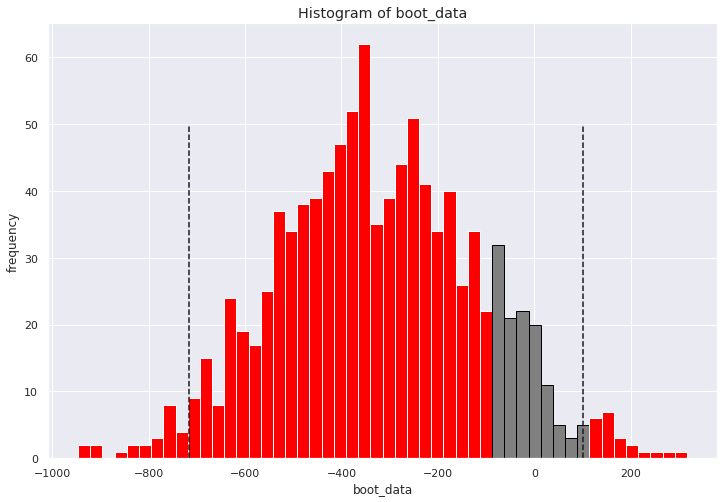

0.11820875867112399

In [51]:
bootstrap_result = get_bootstrap(
    ab_df_a.revenue,  # числовые значения первой выборки
    ab_df_b.revenue)  # числовые значения второй выборки
bootstrap_result['p_value']

#### Вывод
p-value показал значение > 0.05, что не дает нам право отклонить нулевую гипотезу, заданную вначале, о том, что в группах a и b нет различий, однако, это не значит, что их нет.

### Итоговое мнение
В задании есть вопрос: "Какой набор предложений можно считать лучшим?".

Изменения, произведенные в тестовой группе, снизили конверсию, при этом нам не удалось обнаружить какого-либо стат. значимого влияния на ARPPU. Исходя из имеющихся данных, проводимые в эксперименте изменения нецелосообразно выкатывать на всех пользователей.

## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

В первую очередь нам необходимо понимать, для чего создаются подообные события, на что они нацелены.
Как правило, внутреигровые события направлены либо на привлечение новых клиентов, но чаще для поддержания и увеличения лояльности действующих (иногда в подобные события у новых игроков даже нет доступа, и он открывается с определенного уровня) Также такие события создаются с целью увеличить прибыль, ведь зачастуюплатный доступ к событию даёт больше плюшек, чем бесплатный, разрабочки его всячестки рекламируют, обладатели платных доступов получают эксклюзивные предметы, который обычным пользователям получить невозможно.

В связи со всем вышесказанным я предлагаю следубщий набор метрик:

##### Событие 1:
Retention rate 

CR в покупку плтных бонусов

ARPU и ARPPU

Сравнение длительности сессии ASL вне события и во время.

##### Событие 2:
В данном событии принципиальных различий в метриках нет, но особое внимание я рекомендую уделить Показателю Retention, потому что слишком высока сложность механики и необходимость перепроходить все уровки может наоборот отпугнуть пользователей и только обвалить метрику.
